<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/ner_tagging/NER%20tagging%20with%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajag","key":"7c9b32c3baf1bd5e404db6e4e281fc5c"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 34% 9.00M/26.4M [00:00<00:01, 15.6MB/s]
100% 26.4M/26.4M [00:00<00:00, 34.0MB/s]


In [5]:
!unzip entity-annotated-corpus.zip

Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


In [6]:
import time
import math
import random
import spacy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.nn import TransformerEncoder, TransformerEncoderLayer

from itertools import chain
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
datafile = 'ner_dataset.csv'

In [10]:
df = pd.read_csv(datafile, encoding="latin1", error_bad_lines=False)
df = df.fillna(method='ffill')

In [11]:
df.head()

Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O

In [12]:
tags = list(df.Tag.unique())
tags

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

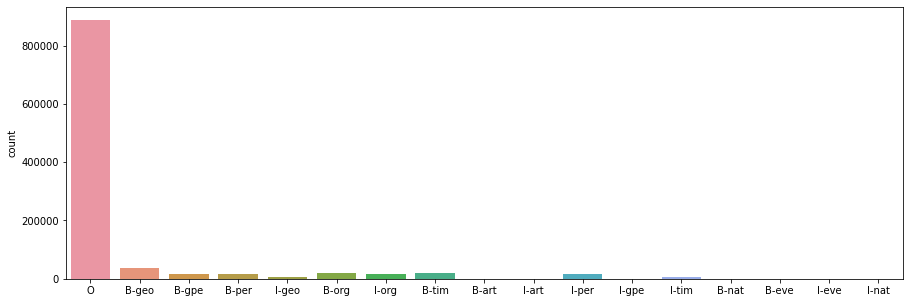

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(df.Tag.values)

In [14]:
num_tags = len(tags)
num_tags

17

In [15]:
agg_func = lambda s: [(w, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func)
lines = [s for s in group]

In [16]:
lines[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [17]:
sentences = [['<START>'] + [tokens[0] for tokens in line] + ['<END'] for line in lines]
tags = [['<START>'] + [tokens[1] for tokens in line] + ['<END'] for line in lines]

In [18]:
len(sentences), len(tags)

(47959, 47959)

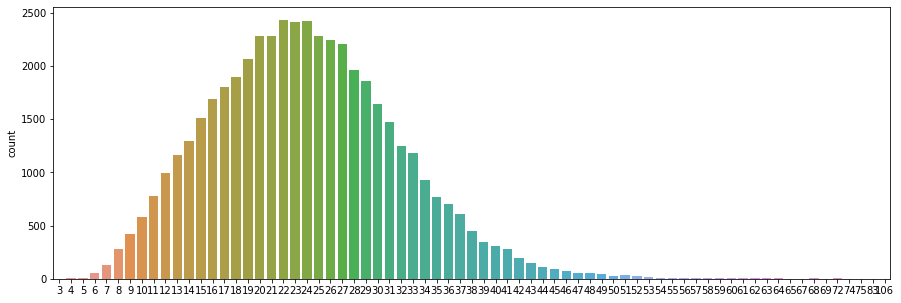

In [19]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

In [20]:
train_sentences, valid_sentences, train_tags, valid_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags = train_test_split(valid_sentences, valid_tags, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(38367, 4796, 4796)

In [21]:
class Vocab:
    def __init__(self, word2id, id2word):
        self.UNK = '<UNK>'
        self.PAD = '<PAD>'
        self.START = '<START>'
        self.END = '<END>'
        self.__word2id = word2id
        self.__id2word = id2word

    def get_word2id(self):
        return self.__word2id

    def get_id2word(self):
        return self.__id2word

    def __getitem__(self, item):
        if self.UNK in self.__word2id:
            return self.__word2id.get(item, self.__word2id[self.UNK])
        return self.__word2id[item]

    def __len__(self):
        return len(self.__word2id)

    def id2word(self, idx):
        return self.__id2word[idx]


In [22]:
def build_vocab(data, freq_cutoff=5, is_tags=False):
    word_counts = Counter(chain(*data))
    valid_words = [w for w, d in word_counts.items() if d >= freq_cutoff]
    valid_words = sorted(valid_words, key=lambda x: word_counts[x], reverse=True)
    valid_words += ['<PAD>']
    word2id = {w: idx for idx, w in enumerate(valid_words)}
    if not is_tags:
        word2id['<UNK>'] = len(word2id)
        valid_words += ['<UNK>']
    return Vocab(word2id=word2id, id2word=valid_words)


In [23]:
words_vocab = build_vocab(train_sentences)
tags_vocab = build_vocab(train_tags, is_tags=True)
len(tags_vocab), tags_vocab.get_id2word()

(20,
 ['O',
  '<START>',
  '<END',
  'B-geo',
  'B-tim',
  'B-org',
  'I-per',
  'B-per',
  'I-org',
  'B-gpe',
  'I-geo',
  'I-tim',
  'B-art',
  'B-eve',
  'I-art',
  'I-eve',
  'I-gpe',
  'B-nat',
  'I-nat',
  '<PAD>'])

In [24]:
MAX_SEN_LEN = 50


In [25]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags, max_len):
        self.sentences = sentences
        self.tags = tags
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]
        tokens, tags = [], []

        for word, t in zip(sentence, tag):
            tokens.append(words_vocab[word])
            tags.append(tags_vocab[t])

        return torch.LongTensor(tokens), torch.LongTensor(tags)

In [26]:
train_dataset = NERDataset(train_sentences, train_tags, MAX_SEN_LEN)
valid_dataset = NERDataset(valid_sentences, valid_tags, MAX_SEN_LEN)
test_dataset = NERDataset(test_sentences, test_tags, MAX_SEN_LEN)

In [27]:
train_dataset[0]

(tensor([   1,  150,  235,   11,   36,   72,   49, 3318,    8, 1977, 4171,  166,
         9619, 9619, 7832,    4,  199,    7, 1385, 9619,   67, 1103,    3,    2]),
 tensor([ 1,  3, 10,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  2]))

In [28]:
BATCH_SIZE = 128

In [29]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    
    for i, (sent, lab) in enumerate(zip(sentences, tags)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]

    return inputs, labels, sent_lengths

In [30]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [31]:
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([128, 52]), torch.Size([128, 52]), 128)

In [39]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [40]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, nhid, nlayers, output_dim, dropout=0.5, src_pad_idx=0):
        super(TransformerModel, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.word_encoder = nn.Embedding(input_dim, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, output_dim)

    def _generate_src_pad_mask(self, src):
        mask = (src == self.src_pad_idx)
        return mask.transpose(0, 1)
    
    def forward(self, src):
        # src => [src_len, batch_size]
        
        device = src.device
        src_pad_mask = self._generate_src_pad_mask(src).to(device)
        # src_pad_mask => [batch_size, src_len]

        src = self.word_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_pad_mask)
        output = self.decoder(output)
        return output

In [41]:
INPUT_DIM = len(words_vocab)
D_MODEL = 128
N_HID = 256
OUTPUT_DIM = len(tags_vocab)
N_LAYERS = 3
N_HEAD = 8
DROPOUT = 0.5
PAD_IDX = words_vocab[words_vocab.PAD]

model = TransformerModel(INPUT_DIM, D_MODEL, N_HEAD, N_HID, N_LAYERS, OUTPUT_DIM, DROPOUT, PAD_IDX)
model = model.to(device)

In [42]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

model.apply(init_weights)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=12

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 1,631,380 trainable parameters


In [44]:
TAG_PAD_IDX = tags_vocab[tags_vocab.PAD]

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TAG_PAD_IDX).to(device)

In [59]:
def categorical_accuracy(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True)
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]]).to(device)

In [60]:
def train(model, iterator, criterion, optimizer, tag_pad_idx, clip):
    model.train()

    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        text = batch[0].transpose(0, 1).to(device)
        tags = batch[1].transpose(0, 1).to(device)
        # text => [seq_len, batch_size]
        # tags => [seq_len, batch_size]

        optimizer.zero_grad()

        logits = model(text)
        # logits => [seq_len, batch_size, output_dim]

        logits = logits.view(-1, logits.shape[-1])
        # logits => [seq_len * batch_size, output_dim]

        tags = tags.contiguous().view(-1)
        # tags => [seq_len * batch_size]

        loss = criterion(logits, tags)
        acc = categorical_accuracy(logits, tags, tag_pad_idx)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [61]:
def evaluate(model, iterator, criterion, trg_pad_idx):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].transpose(0, 1).to(device)
            tags = batch[1].transpose(0, 1).to(device)
            # text => [seq_len, batch_size]
            # tags => [seq_len, batch_size]

            optimizer.zero_grad()

            logits = model(text)
            # logits => [seq_len, batch_size, output_dim]

            logits = logits.view(-1, logits.shape[-1])
            # logits => [seq_len * batch_size, output_dim]

            tags = tags.contiguous().view(-1)
            # tags => [seq_len * batch_size]

            loss = criterion(logits, tags)
            acc = categorical_accuracy(logits, tags, trg_pad_idx)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [48]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [62]:
N_EPOCHS = 10
CLIP = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_data_loader, criterion, optimizer, TAG_PAD_IDX, CLIP)
    valid_loss, val_acc = evaluate(model, valid_data_loader, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f} | Val. Loss: {valid_loss:.3f} | Val Acc: {val_acc * 100:.2f}')


Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.724 | Train Acc: 87.94 | Val. Loss: 0.391 | Val Acc: 88.67
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.321 | Train Acc: 90.69 | Val. Loss: 0.231 | Val Acc: 92.27
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.239 | Train Acc: 91.98 | Val. Loss: 0.221 | Val Acc: 92.17
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.219 | Train Acc: 92.36 | Val. Loss: 0.206 | Val Acc: 92.39
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.208 | Train Acc: 92.48 | Val. Loss: 0.201 | Val Acc: 92.53
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.198 | Train Acc: 92.68 | Val. Loss: 0.191 | Val Acc: 93.14
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.187 | Train Acc: 93.08 | Val. Loss: 0.170 | Val Acc: 93.57
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.175 | Train Acc: 93.46 | Val. Loss: 0.172 | Val Acc: 93.58
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.168 | Train Acc: 93.71 | Val. Loss: 0.159 | Val Acc: 94.00
Epoch: 10 | Epoch Time: 0m 9s
	Train Loss: 0.160 | Train Acc: 94

In [63]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [65]:
test_loss, test_acc = evaluate(model, test_data_loader, criterion, TAG_PAD_IDX)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}')


Test Loss: 0.158 | Test Acc: 94.41


In [66]:

def cal_metrics(model, iterator):
    model.eval()

    fin_outputs = []
    fin_targets = []

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].transpose(0, 1).to(device)
            tags = batch[1].transpose(0, 1).to(device)


            predictions = model(sentences)
            # predictions => [seq_len, batch_size, output_dim]
            _, predictions = torch.max(predictions, dim=2)

            fin_outputs.extend(predictions.detach().cpu().numpy().tolist())
            fin_targets.extend(tags.detach().cpu().numpy().tolist())
        
    assert len(fin_outputs) == len(fin_targets)
    mlb = MultiLabelBinarizer()
    trans_trg = mlb.fit_transform(fin_targets)
    trans_pred = mlb.transform(fin_outputs)

    cf = metrics.classification_report(trans_trg, trans_pred)
    print(cf)

In [67]:
cal_metrics(model, test_data_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1835
           1       0.03      1.00      0.06        38
           2       0.00      0.00      0.00      1256
           3       0.93      0.97      0.95      1157
           4       0.94      0.85      0.89       941
           5       0.91      0.41      0.56       835
           6       0.65      0.98      0.78       701
           7       0.91      0.76      0.83       676
           8       0.84      0.71      0.77       764
           9       0.90      0.93      0.91       728
          10       0.59      0.04      0.08       528
          11       0.00      0.00      0.00       470
          12       0.00      0.00      0.00        46
          13       0.00      0.00      0.00        34
          14       0.00      0.00      0.00        45
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00        15
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
